In [1]:
# are the flux errors in the original ones okay?
# I need to take sqrt(counts*gain), or sqrt(counts*photoelectrons)
# it seems like the gain has been applied inthe deblazed spectra
# but probably not in the original spectra?
# the iodfits file only has flux, so there are no errors there.

# oh wait I'm supposed to calculate the errors in the raw file.

In [2]:
from astropy.io import fits
from pylab import *

In [3]:
fits.open('./data/raw_hires_spectra/cadence_raw_rj122.81.fits').info()

Filename: ./data/raw_hires_spectra/cadence_raw_rj122.81.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     722   (4021, 16)   float32   


Text(0.5, 1.0, 'cks-k00003_rj122.81.fits order 14')

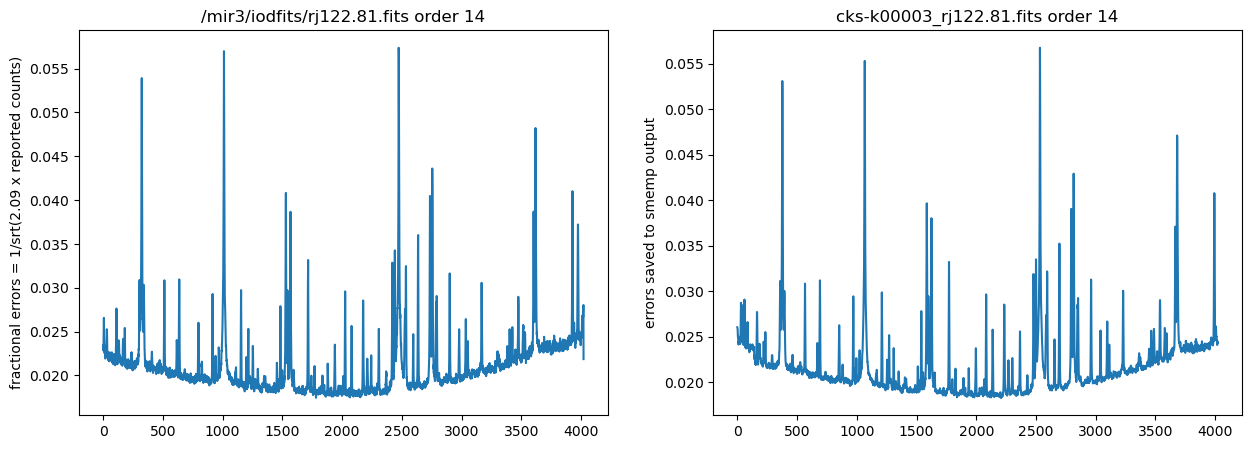

In [4]:
# calculating errors from raw data
# I assume the gain has been applied, since the values 
# are similar to the values of the photo-electrons in the de-blazed spectra

figure(figsize=(15,5))

subplot(121)
raw_data = fits.open('./data/raw_hires_spectra/cadence_raw_rj122.81.fits')
photo_electrons = raw_data[0].data*2.09 # apply gain correction
flux_err_from_raw_data = 1/sqrt(photo_electrons[13])
plot(flux_err_from_raw_data)
ylabel('fractional errors = 1/srt(2.09 x reported counts)')
title('/mir3/iodfits/rj122.81.fits order 14')

subplot(122)
smemp_data = fits.open('./data/cks-spectra_shifted_resampled_r/order14/cks-k00003_rj122.81.fits')
flux_err_from_smemp = smemp_data[1].data['serr']
plot(flux_err_from_smemp)
ylabel('errors saved to smemp output')
title('cks-k00003_rj122.81.fits order 14')

In [5]:
# okay, these fluxes don't look wrong to me. 
# so I don't think I should spend time transferring them over.
# but then the histogram is still a mystery to me.
# should I check the other orders?

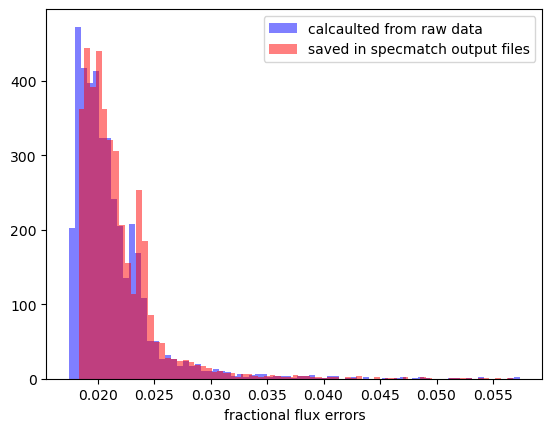

In [6]:
# let me plot both of them now
# maybe this is recovering the shift?
# I think I should plot histograms instead of the difference

hist(flux_err_from_raw_data, color='b', alpha=0.5, label='calcaulted from raw data', bins=75)
hist(flux_err_from_smemp, color='r', alpha=0.5, label='saved in specmatch output files', bins=75)
xlabel('fractional flux errors')
legend()

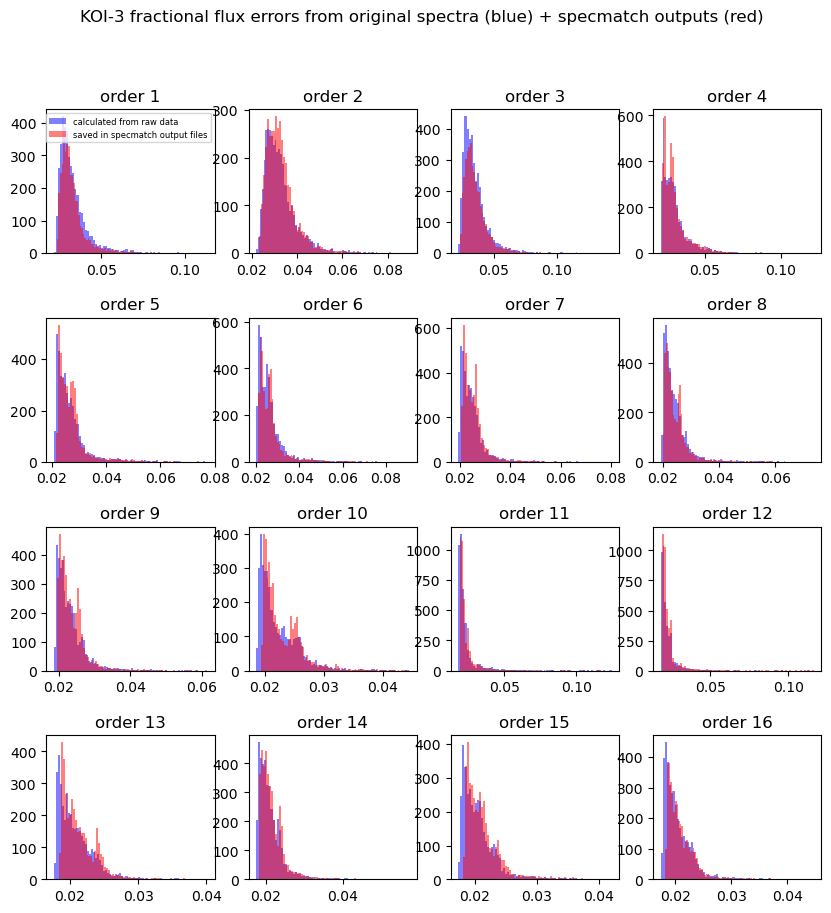

In [7]:
# let me look at these histograms for all the orders

figure(figsize=(10,10))
subplots_adjust(hspace=0.45)
suptitle('KOI-3 fractional flux errors from original spectra (blue) + specmatch outputs (red)')
for i in range(len(raw_data[0].data)):
    
    subplot(4,4,i+1)
    raw_flux_err = 1/sqrt(raw_data[0].data[i]*2.09) # apply gain correction
    hist(raw_flux_err, color='b', alpha=0.5, bins=75, label='calculated from raw data')
    
    smemp_file = './data/cks-spectra_shifted_resampled_r/order{}/cks-k00003_rj122.81.fits'.format(i+1)
    smemp_flux_err = fits.open(smemp_file)[1].data['serr']
    hist(smemp_flux_err, color='r', alpha=0.5, bins=75, label='saved in specmatch output files')
    title('order {}'.format(i+1))
    if i==0:
        legend(fontsize=6)

# two spectra from the same night

In [8]:
# plot difference of spectra
# it looks like none of these have wavelength, errors in the original spectra

from astropy.io import fits
from pylab import *

s716 = fits.open('/Users/isabelangelo/Desktop/rj442.716_reduced.fits')[0].data
s717 = fits.open('/Users/isabelangelo/Desktop/rj442.717_reduced.fits')[0].data
wav = fits.open('./data/cks-spectra/cks-k00001_rj122.742.fits')[2].data

# SNR check: do the spectra have a comparable number of counts?
# based on this figure it looks like they do

from specmatchemp.spectrum import read_hires_fits
from specmatchemp.specmatch import SpecMatch
import specmatchemp.library
import glob
import os

# load specmatch library for reference spectra
lib = specmatchemp.library.read_hdf()

rescaled_orders = []
def shift_and_save_orders(filename):
    
    # load spectrum + create SpecMatch object
    KOI_spectrum = read_hires_fits(filename)
    sm_KOI = SpecMatch(KOI_spectrum, lib)
    w_to_resample_to = sm_KOI.target_unshifted.w
    
    # shift spectrum
    shifted_spectrum = sm_KOI.shift()
    
    rescaled_orders=[]
    # rescale to each order and save
    for order_idx in range(w_to_resample_to.shape[0]):
        # resample order to original wavelength scale
        w_order = w_to_resample_to[order_idx]
        rescaled_order = shifted_spectrum.rescale(w_order)
        # save to list
        rescaled_orders.append(rescaled_order)
    return rescaled_orders

s716db = shift_and_save_orders('/Users/isabelangelo/Desktop/rj442.716_db.fits')
s717db = shift_and_save_orders('/Users/isabelangelo/Desktop/rj442.717_db.fits')

Reading library from /Users/isabelangelo/.specmatchemp/library.h5


/Users/isabelangelo/opt/anaconda3/lib/python3.8/site-packages/SpecMatch_Emp-0.3-py3.8.egg/specmatchemp/spectrum.py:56: RuntimeWarning: invalid value encountered in cast


Shifting spectrum
Shifting spectrum rj442.716_db
Attempting shift to spectrum NSO, median cross-correlation peak = 1.32
Attempting shift to spectrum 123239, median cross-correlation peak = 1.52
Attempting shift to spectrum 222368, median cross-correlation peak = 0.97
Attempting shift to spectrum 216899, median cross-correlation peak = 0.97
Best reference for shifting: 123239
Shifting entire spectrum
Shifting spectrum
Shifting spectrum rj442.717_db
Attempting shift to spectrum NSO, median cross-correlation peak = 1.31
Attempting shift to spectrum 123239, median cross-correlation peak = 1.50
Attempting shift to spectrum 222368, median cross-correlation peak = 0.96
Attempting shift to spectrum 216899, median cross-correlation peak = 0.97
Best reference for shifting: 123239
Shifting entire spectrum


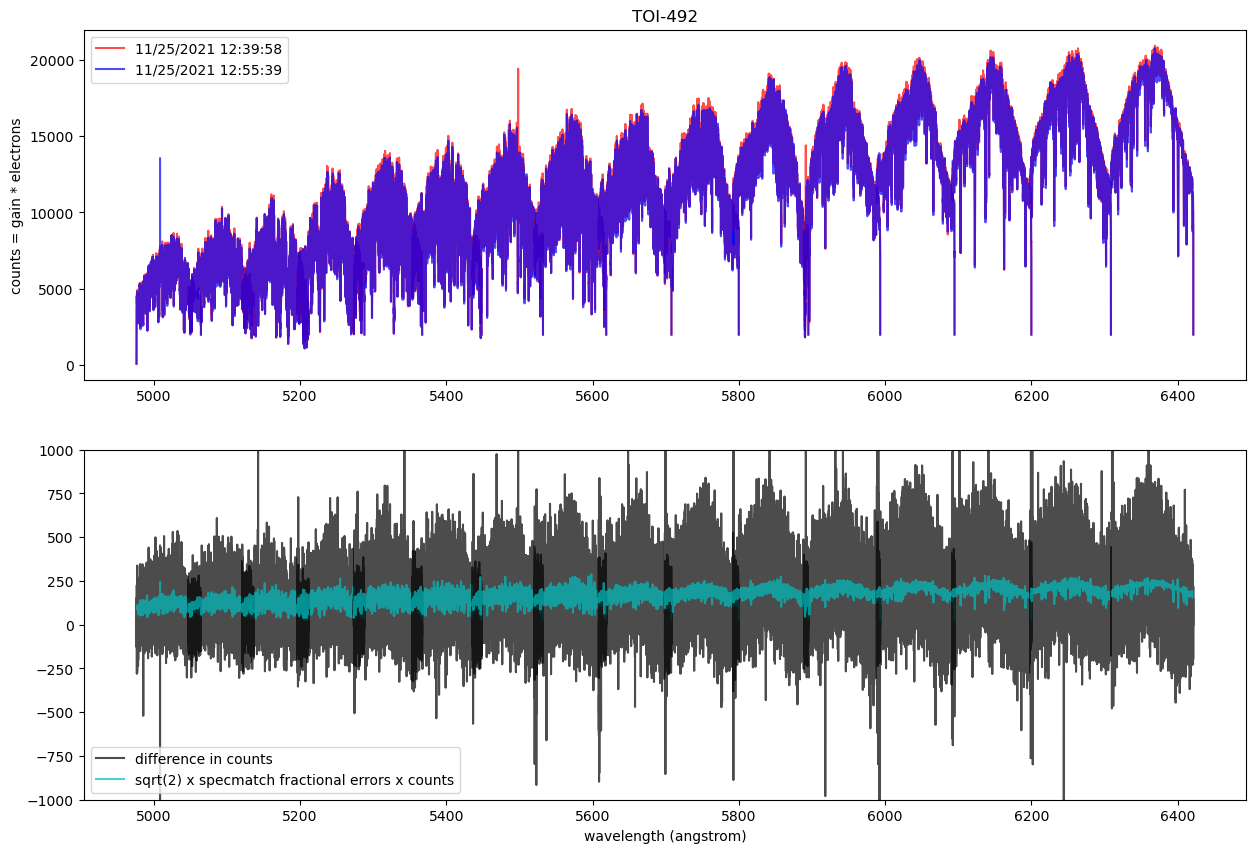

In [9]:
figure(figsize=(15,10))

subplot(211);title('TOI-492')
for i in range(len(s716)):
    if i==0:
        plot(wav[i], 2*s716[i], 'r-', alpha=0.7, label='11/25/2021 12:39:58')
        plot(wav[i], 2*s717[i], 'b-', alpha=0.7, label='11/25/2021 12:55:39')
    else:
        plot(wav[i], 2*s716[i], 'r-', alpha=0.7)
        plot(wav[i], 2*s717[i], 'b-', alpha=0.7)
ylabel('counts = gain * electrons')
legend()#;xlim(5140,5200)
    
subplot(212)
for i in range(len(s716)):
    if i==0:
        plot(wav[i], 2*s716[i]-2*s717[i], 'k-', alpha=0.7, label='difference in counts')
        plot(wav[i], sqrt(2)*s717db[i].serr*s717[i]*2, 'c-', alpha=0.7, 
             label='sqrt(2) x specmatch fractional errors x counts')
    else:
        plot(wav[i], 2*s716[i]-2*s717[i], 'k-', alpha=0.7)
        plot(wav[i], sqrt(2)*s717db[i].serr*s717[i]*2, 'c-', alpha=0.7)
ylim(-1000,1000);xlabel('wavelength (angstrom)');legend()#;xlim(5140,5200)
#ylabel('difference')

Text(0, 0.5, 'RMS of difference')

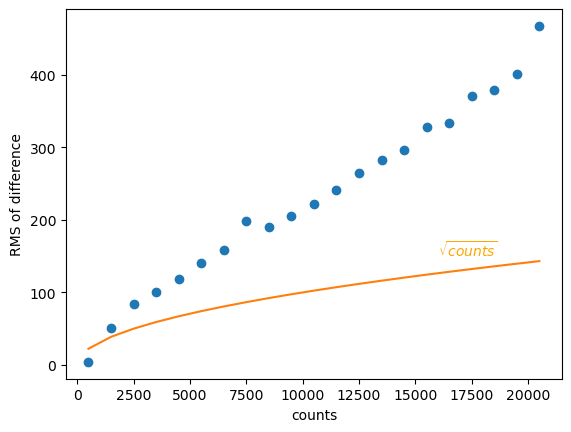

In [68]:
# arrays of counts
# these are from jump with _reduced.fits filenames
# so I assumed the gain corection had not been applied
A = s716.flatten()*2.09
B = s717.flatten()*2.09

# Define bin edges
bin_edges = np.arange(0, 22000, 1000)

# Bin the data in A
bin_indices = np.digitize(A, bin_edges)

# Dictionary to hold the result
binned_B = {}
binned_A = {}

# Iterate through each bin and get corresponding elements in B
for i in range(1, len(bin_edges)):
    # Get indices of elements in A that fall into the current bin
    indices_in_bin = np.where(bin_indices == i)[0]
    # Get corresponding elements in A, B
    binned_A[i] = A[indices_in_bin]
    binned_B[i] = B[indices_in_bin]
    
rms_values = []
for bin in binned_A.keys():
    dif = binned_A[bin] - binned_B[bin]
    rms = sqrt(sum(dif**2)/len(dif))
    rms_values.append(rms)
bin_centers = [(bin_edges[i+1] + bin_edges[i])/2 for i in range(len(rms_values))]
    
plot(bin_centers, rms_values, 'o')
plot(bin_centers, sqrt(bin_centers))
text(16000,150,'$\sqrt{counts}$', color='orange')
xlabel('counts')
ylabel('RMS of difference')

In [ ]:
# does the way I calculated it make sense?
# essentially what I did is, 
# I took all the data in one array and binned it
# then I got the indices in each bin and evalued the difference between the arrays at those indices
# then I plotted the sqrt(sum(difference)/ n_bin) for each bin